### This notebook focuses on developing machine learning models using **XGBoost** and **LightGBM** with GPU support. We will compare their performances at the end.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Check if CUDA is available
import torch
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [3]:
# Load the preprocessed data
feature_engineered_data_path = "../data/processed/feature_engineered_energy_data.csv"
df = pd.read_csv(feature_engineered_data_path)

In [4]:
# Display the first few rows and information about the DataFrame
print("Data Overview:")
print(df.head())
print("\nData Information:")
print(df.info())
print(f"\nDataFrame Shape: {df.shape}")

Data Overview:
   SolarEnergy  WindEnergy  HydroEnergy  OtherRenewableEnergy  \
0    -0.337886    1.546596     0.937605              0.251720   
1    -1.064628   -1.214041    -1.358563              1.190797   
2     0.415641    0.703726    -1.486331              1.554937   
3     1.184973   -1.018315    -0.936947             -1.205960   
4    -0.571677    0.066936    -0.084731             -0.827460   

   TotalRenewableEnergy  Year Country  TotalRenewableEnergyPerCapita  \
0              1.423478  2000     USA                   1.423478e-06   
1             -1.827414  2001     USA                  -1.827414e-06   
2             -0.239904  2002     USA                  -2.399037e-07   
3             -0.983877  2003     USA                  -9.838768e-07   
4             -0.400771  2004     USA                  -4.007708e-07   

   SolarToWindRatio  HydroToOtherRatio  YearlyGrowthRate  SolarEnergy.1  \
0         -0.218470           3.724774          0.000000      -0.337886   
1          

In [5]:
# Define features (X) and target (y)
X = df.drop(columns=['TotalRenewableEnergy', 'Country'])
y = df['TotalRenewableEnergy']

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Initialize models with GPU support
models = {
    "XGBoost": xgb.XGBRegressor(
        tree_method='hist',  # Use 'hist' with CUDA
        device='cuda',      # Enable CUDA
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        device='gpu',  # Use GPU
        objective='regression',
        metric='rmse',
        random_state=42
    )
}


In [8]:
# Train and evaluate the models
results = {}
for name, model in models.items():
    print(f"\nTraining model: {name}")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {
        "MSE": mse,
        "R2": r2
    }

    # Display the results
    print(f"  MSE: {mse:.2f}")
    print(f"  R2: {r2:.2f}")


Training model: XGBoost


/home/abdellah-ennajari/miniconda3/envs/ai/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:28:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


  MSE: 0.00
  R2: 1.00

Training model: LightGBM
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 15
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce MX250, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0.00 MB) transferred to GPU in 0.002324 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.002417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [9]:
# Compare model performances
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
               MSE        R2
XGBoost   0.003214  0.996345
LightGBM  0.013189  0.985004


/tmp/ipykernel_43280/4003336146.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['R2'], palette='viridis')


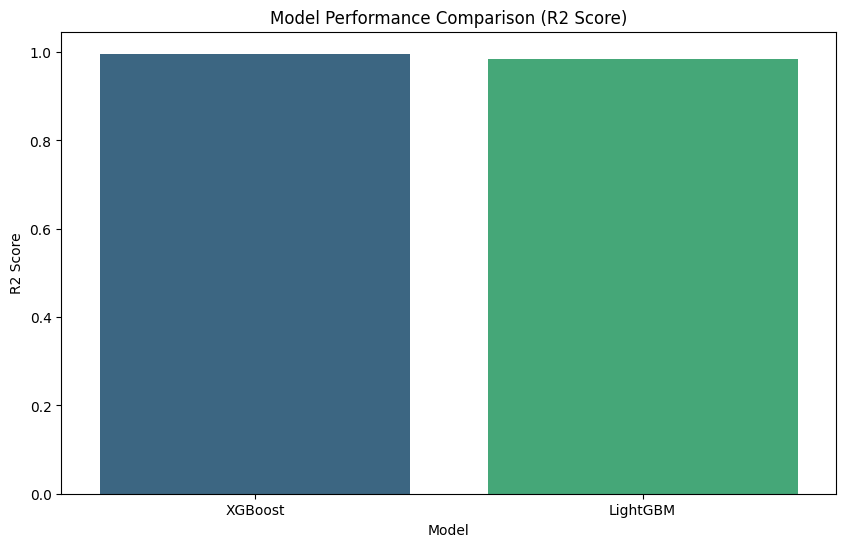

In [10]:
# Visualize model performances
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R2'], palette='viridis')
plt.title("Model Performance Comparison (R2 Score)")
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.show()

/tmp/ipykernel_43280/3605495687.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=xgb_importance_df, palette='magma')


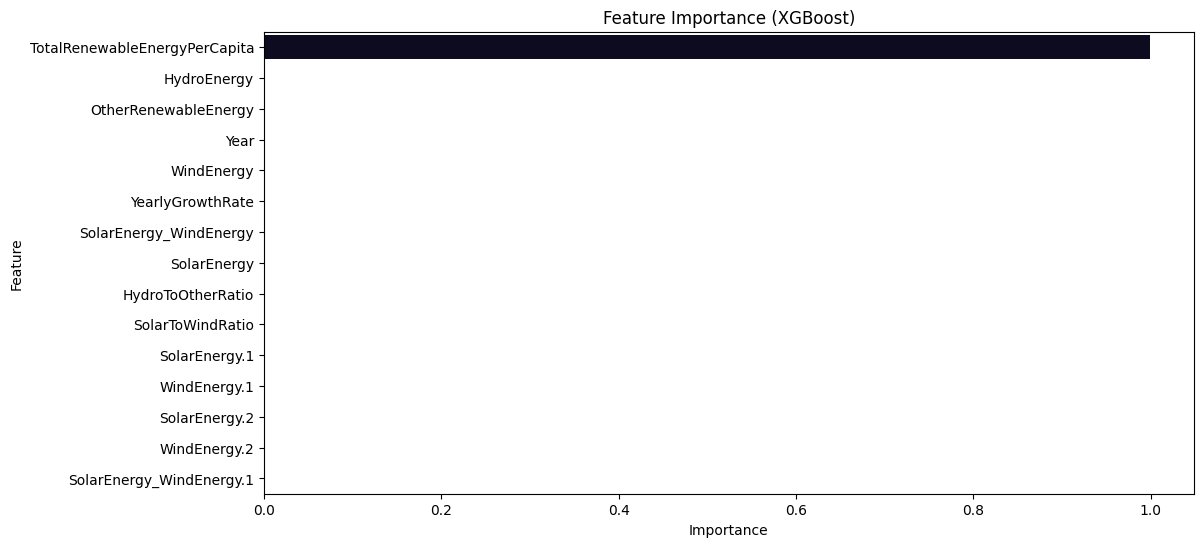

In [11]:
# Feature importance for XGBoost
if "XGBoost" in models:
    xgb_model = models["XGBoost"]
    xgb_importances = xgb_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for feature importances
    xgb_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": xgb_importances
    }).sort_values(by="Importance", ascending=False)

    # Visualize feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Importance", y="Feature", data=xgb_importance_df, palette='magma')
    plt.title("Feature Importance (XGBoost)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

/tmp/ipykernel_43280/2073551235.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=lgb_importance_df, palette='coolwarm')


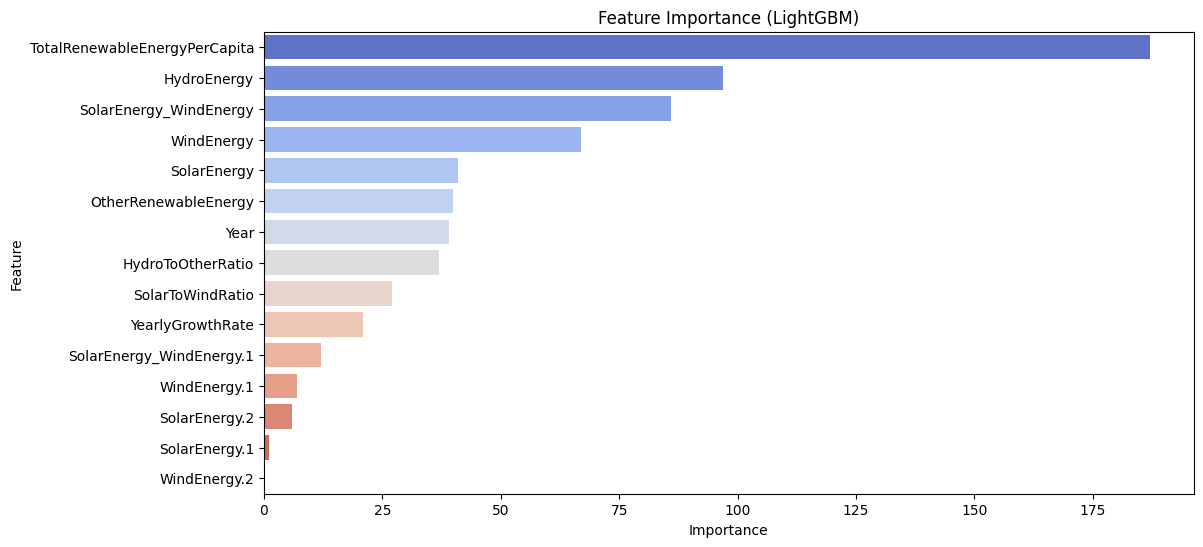

In [12]:
# Feature importance for LightGBM
if "LightGBM" in models:
    lgb_model = models["LightGBM"]
    lgb_importances = lgb_model.feature_importances_

    # Create a DataFrame for feature importances
    lgb_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": lgb_importances
    }).sort_values(by="Importance", ascending=False)

    # Visualize feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Importance", y="Feature", data=lgb_importance_df, palette='coolwarm')
    plt.title("Feature Importance (LightGBM)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

In [13]:
# Save the best model
best_model = models["XGBoost"] if results["XGBoost"]["R2"] > results["LightGBM"]["R2"] else models["LightGBM"]
model_save_path = "../data/models/trained_models.pkl"
joblib.dump(best_model, model_save_path)
print(f"\nBest model saved at: {model_save_path}")


Best model saved at: ../data/models/trained_models.pkl
